In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pvlib
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [2]:
weather = pd.read_csv("weather.csv")
temp_data = pd.DataFrame(weather.tavg)
weather.index = pd.date_range(start='2012-01-01', end='20-07-25', freq='D')

In [3]:
temp_data.index = weather.index

In [4]:
import pandas as pd
import pvlib

# Set location information (latitude, longitude, and elevation)
latitude = 12.971598
longitude = 77.594562
altitude = 920
tz = 'Asia/Kolkata'

weather_data = temp_data
times = weather_data.index
location = pvlib.location.Location(latitude, longitude, tz=tz)

# Calculate solar position
solar_position = pvlib.solarposition.get_solarposition(times, latitude, longitude)

# Calculate extraterrestrial radiation
dni_extra = pvlib.irradiance.get_extra_radiation(times)

# Calculate air mass, replacing NaN values with a default value (e.g., 10)
airmass = pvlib.atmosphere.get_relative_airmass(solar_position['apparent_zenith']).fillna(10)

# Assuming no direct horizontal irradiance (dhi) available, set it to zero
dhi = pd.Series(0, index=times)

# Calculate the solar panel tilt and azimuth dynamically based on solar position
solar_panel_tilt = 90 - solar_position['apparent_elevation']
solar_panel_azimuth = solar_position['azimuth']

# Ensure tilt values are within a reasonable range (0 to 90 degrees)
solar_panel_tilt = solar_panel_tilt.clip(0, 90)

# Use temperature data from your CSV file
temp_air = weather_data['tavg']

# Calculate total radiation on a tilted surface with dynamic tilt and azimuth
total_irradiance_dynamic = pvlib.irradiance.get_total_irradiance(
    solar_panel_tilt, solar_panel_azimuth, solar_position['apparent_zenith'],
    solar_position['azimuth'], dni_extra, dhi, airmass)

# Convert irradiance to energy (assuming a 1 kW system)
system_size_kw = 3
energy_dynamic = total_irradiance_dynamic * system_size_kw/1000

# Create a pandas DataFrame to store the results
result_df_dynamic = pd.DataFrame(index=times)
result_df_dynamic['Energy_Generated_KWh'] = energy_dynamic['poa_global']
result_df_dynamic['Temperature_C'] = temp_air  # Use the existing temperature data

# Print the resulting DataFrame with dynamic tilt and azimuth
print(result_df_dynamic)


            Energy_Generated_KWh  Temperature_C
2020-01-01              4.071623           22.0
2020-01-02              4.069567           22.2
2020-01-03              4.067503           23.4
2020-01-04              4.065434           23.6
2020-01-05              4.063364           24.2
...                          ...            ...
2022-07-21              3.941051           23.7
2022-07-22              3.941010           23.2
2022-07-23              3.941004           23.1
2022-07-24              3.941034           22.8
2022-07-25              3.941100           24.1

[937 rows x 2 columns]


In [8]:
weather_data

,tavg
2020-01-01,22.0
2020-01-02,22.2
2020-01-03,23.4
2020-01-04,23.6
2020-01-05,24.2
...,...
2022-07-21,23.7
2022-07-22,23.2
2022-07-23,23.1
2022-07-24,22.8


In [5]:
solar_position

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2020-01-01,106.998592,106.998592,-16.998592,-16.998592,110.480089,-3.081724
2020-01-02,107.096799,107.096799,-17.096799,-17.096799,110.382401,-3.555873
2020-01-03,107.192842,107.192842,-17.192842,-17.192842,110.276913,-4.024309
2020-01-04,107.286611,107.286611,-17.286611,-17.286611,110.163675,-4.486515
2020-01-05,107.377999,107.377999,-17.377999,-17.377999,110.042736,-4.941995
...,...,...,...,...,...,...
2022-07-21,98.186342,98.186342,-8.186342,-8.186342,66.646776,-6.427244
2022-07-22,98.254215,98.254215,-8.254215,-8.254215,66.831438,-6.473273
2022-07-23,98.321633,98.321633,-8.321633,-8.321633,67.022291,-6.510060
2022-07-24,98.388526,98.388526,-8.388526,-8.388526,67.219282,-6.537452


In [6]:
solar_panel_azimuth

2020-01-01    110.480089
2020-01-02    110.382401
2020-01-03    110.276913
2020-01-04    110.163675
2020-01-05    110.042736
                 ...    
2022-07-21     66.646776
2022-07-22     66.831438
2022-07-23     67.022291
2022-07-24     67.219282
2022-07-25     67.422358
Freq: D, Name: azimuth, Length: 937, dtype: float64

<Axes: >

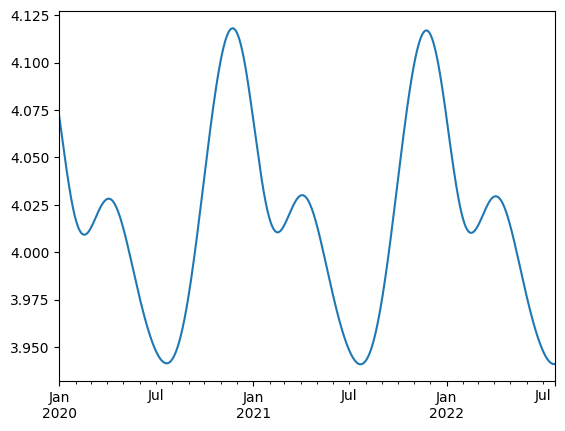

In [7]:
result_df_dynamic['Energy_Generated_KWh'].plot()

In [7]:
result_df_dynamic['Energy_Generated_KWh'] = scaler.fit_transform(np.reshape(result_df_dynamic['Energy_Generated_KWh'], (-1,1))) * 5
df = result_df_dynamic["Temperature_C"]
result_df_dynamic["Temperature_C"] = (df - df.min())*(35-2)/(df.max()-df.min()) + 2

In [8]:
print(result_df_dynamic)

            Energy_Generated_KWh  Temperature_C
2020-01-01              3.687646      12.607143
2020-01-02              3.629639      13.196429
2020-01-03              3.571416      16.732143
2020-01-04              3.513067      17.321429
2020-01-05              3.454684      19.089286
...                          ...            ...
2022-07-21              0.004560      17.616071
2022-07-22              0.003392      16.142857
2022-07-23              0.003217      15.848214
2022-07-24              0.004055      14.964286
2022-07-25              0.005924      18.794643

[937 rows x 2 columns]


In [9]:
result_df_dynamic.to_csv("gen-temp.csv")